## Loading data into files and containers

In [2]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D

### Downloading data set should not need to do know


In [3]:
#!chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && cp kaggle.json ~/.kaggle/ && echo 'Done'
#!ls
#!kaggle datasets download --force -d kmader/skin-cancer-mnist-ham10000

In [4]:
archive = 'skin-cancer-mnist-ham10000.zip'
cur_dir = os.getcwd()
a = os.path.join(cur_dir, archive)
print(a)

/content/skin-cancer-mnist-ham10000.zip


In [5]:
#with ZipFile(archive , 'r') as zip_ref:
#    zip_ref.extractall('./')

In [6]:
path_1 = 'HAM10000_images_part_1'
path_2 = 'HAM10000_images_part_2'
path_meta = 'HAM10000_metadata.csv'

### Read data

In [7]:
file_path1 = os.path.join(cur_dir, path_1) #HAM10000_images_part_1
file_path2 = os.path.join(cur_dir, path_2) #HAM10000_images_part_2

len(os.listdir(file_path1)), len(os.listdir(file_path2))

(5000, 5015)

In [8]:
metadata_path = os.path.join(cur_dir, path_meta)
df = pd.read_csv(metadata_path)
df['lesion_id'].unique().shape, df

##
df_ids_img = df[['lesion_id','image_id','dx']]
df_ids_img['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

This shows that we have 7470 unique images and duplicates that are either different views or magnified.

### First folder processing

In [9]:
num_1 = int( len(os.listdir(file_path1)) / 2 ) # Number of images to use

In [10]:
size = (240,240)

imgs_1 = [ np.zeros((size[0],size[1],3),'float32') for k in  range( num_1 ) ]
len(imgs_1)

2500

In [11]:
target = np.zeros( num_1 ).astype('str') # Convert to int later

target.shape, 

((2500,),)

In [12]:
sizes = []
min = 100
max = -1

for img in imgs_1:
    if( img.shape not in sizes ):
        sizes.append(img.shape)
sizes

[(240, 240, 3)]

In [13]:
for i, img in enumerate( os.listdir(file_path1) ): #Loop through each file
    if( i < num_1 ):
        p_id = img.split('.')[0]#Extract id
        target[i] = df[ df['image_id'] == p_id ]['dx'].iloc[0] # Target Feature
        imgs_1[i] = cv.resize( cv.imread( os.path.join(file_path1, img) ), size ) # Load data into array 
        # May want to change the color scheme, but we will see                   

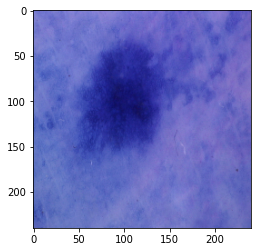

In [14]:
plt.imshow(imgs_1[0])

### normalize images

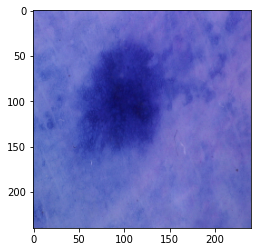

In [15]:
imgs_1 = [ img / 255.0 for img in imgs_1 ]
plt.imshow(imgs_1[0])

In [16]:
imgs_1[0]

array([[[0.49411765, 0.51372549, 0.81568627],
        [0.45882353, 0.4745098 , 0.80784314],
        [0.43137255, 0.4627451 , 0.8       ],
        ...,
        [0.36862745, 0.35294118, 0.74509804],
        [0.35686275, 0.32941176, 0.71764706],
        [0.37254902, 0.3372549 , 0.73333333]],

       [[0.5254902 , 0.51764706, 0.83137255],
        [0.47843137, 0.49019608, 0.82352941],
        [0.44313725, 0.46666667, 0.80784314],
        ...,
        [0.38431373, 0.36470588, 0.7372549 ],
        [0.34509804, 0.34117647, 0.70980392],
        [0.36470588, 0.35686275, 0.72156863]],

       [[0.50588235, 0.50980392, 0.83921569],
        [0.47843137, 0.50588235, 0.82745098],
        [0.47058824, 0.47843137, 0.81568627],
        ...,
        [0.41568627, 0.37647059, 0.76470588],
        [0.37647059, 0.34901961, 0.7254902 ],
        [0.4       , 0.36470588, 0.73333333]],

       ...,

       [[0.3372549 , 0.4       , 0.70588235],
        [0.36078431, 0.41568627, 0.72156863],
        [0.34117647, 0

### Shuffle data


In [17]:
# Put targets and photos together
group_1 = [0 for i in range(num_1)]
for i in range(num_1):
    group_1[i] = [ imgs_1[i], target[i] ]

In [18]:
# Shuffle
np.random.shuffle(group_1)

# Ungroup
for i in range(num_1):
    imgs_1[i] = group_1[i][0]
    target[i] = group_1[i][1]
    

In [19]:
np.zeros((2,4))[0]

array([0., 0., 0., 0.])

### Convert target feature into numerical data  Format Data

In [20]:
target_binary = []
for k in target:
  if k == 'nv':
    target_binary.append(0)
  else:
    target_binary.append(1)
    
for k in range(5):
    print(target_binary[k])

1
1
0
0
0


In [21]:
cnt = [0,0]
for k in target_binary:
  cnt[k] += 1

cnt

[1737, 763]

Notice that data is skewed towards non-cancerous pictures

### Split data

In [22]:
train_split = int ( num_1 * 0.8 )
train_x = np.array(imgs_1[:train_split])
train_y = np.array(target_binary[:train_split])

val_x = np.array(imgs_1[train_split:])
val_y = np.array(target_binary[train_split:])

In [23]:
train_y_bin = np.array(target_binary[:train_split])

val_y_bin = np.array(target_binary[train_split:])

len(val_y_bin), len( train_y )

(500, 2000)

In [24]:
cnt = [0 for k in range(2)]
for k in target_binary:
    cnt[k] += 1

cnt, 3431 / (3431 + 1569)

([1737, 763], 0.6862)

In [29]:
filter1 = 16
filter2 = 32
filter3 = 64

input_size = (size[0], size[1], 3)
pool_size = (2,2)

In [30]:
#First make our layers
input_layer = tf.keras.layers.Input(shape = input_size, name = 'input')
conv1 = Conv2D(filter1, (8,8), activation='relu', padding='same', name = 'c1')(input_layer)
pool1 = MaxPool2D(pool_size, name = 'p1')(conv1)
conv2 = Conv2D(filter2, (4,4), activation = 'relu', padding = 'same', name = 'c2')(pool1)
pool2 = MaxPool2D(pool_size, name = 'p2')(conv2)
conv3 = Conv2D(filter3, (2,2), activation = 'relu', padding = 'same', name = 'c3')(pool2)
pool3 = MaxPool2D(pool_size, name = 'p3')(conv3)
flatten = tf.keras.layers.Flatten(name = 'flatten')(pool3)
dense1 = Dense(128,activation = 'relu',name = 'd1')(flatten)
output_layer = Dense(1, activation = 'sigmoid',name = 'out')(dense1)

In [31]:
model2 = tf.keras.Model(input_layer, output_layer, name = 'Model2')

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8)
model2.compile(
    optimizer = 'Adam',
    loss = 'binary_crossentropy', # Multiclass Problem
    metrics = 'accuracy',
)

model2.summary()

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 240, 240, 3)]     0         
                                                                 
 c1 (Conv2D)                 (None, 240, 240, 16)      3088      
                                                                 
 p1 (MaxPooling2D)           (None, 120, 120, 16)      0         
                                                                 
 c2 (Conv2D)                 (None, 120, 120, 32)      8224      
                                                                 
 p2 (MaxPooling2D)           (None, 60, 60, 32)        0         
                                                                 
 c3 (Conv2D)                 (None, 60, 60, 64)        8256      
                                                                 
 p3 (MaxPooling2D)           (None, 30, 30, 64)        0    

In [32]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience = 7
    )

EPOCH = 100

#Train the model
history2 = model2.fit(
    train_x,
    train_y_bin,
    epochs = EPOCH,
    batch_size = 512,
    callbacks = [early_stop]
)

Epoch 1/100
4/4 [==============================] - 6s 931ms/step - loss: 2.1336 - accuracy: 0.5860
Epoch 2/100
4/4 [==============================] - 2s 414ms/step - loss: 0.9072 - accuracy: 0.3960
Epoch 3/100
4/4 [==============================] - 2s 411ms/step - loss: 0.6161 - accuracy: 0.6910
Epoch 4/100
4/4 [==============================] - 2s 410ms/step - loss: 0.5928 - accuracy: 0.6910
Epoch 5/100
4/4 [==============================] - 2s 408ms/step - loss: 0.5568 - accuracy: 0.6855
Epoch 6/100
4/4 [==============================] - 2s 411ms/step - loss: 0.5432 - accuracy: 0.6975
Epoch 7/100
4/4 [==============================] - 2s 406ms/step - loss: 0.5424 - accuracy: 0.7095
Epoch 8/100
4/4 [==============================] - 2s 410ms/step - loss: 0.5186 - accuracy: 0.7190
Epoch 9/100
4/4 [==============================] - 2s 412ms/step - loss: 0.5457 - accuracy: 0.7175
Epoch 10/100
4/4 [==============================] - 2s 411ms/step - loss: 0.5235 - accuracy: 0.7225
Epoch 11/

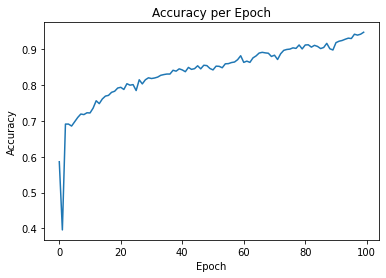

In [33]:
plt.title("Accuracy per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(0,len(history2.history['accuracy'])), history2.history['accuracy'])


In [34]:
predictions = model2.predict(val_x)

(array([254.,  26.,  22.,  27.,  11.,  24.,  16.,  15.,  34.,  71.]),
 array([2.7029117e-11, 9.9992737e-02, 1.9998547e-01, 2.9997823e-01,
        3.9997095e-01, 4.9996370e-01, 5.9995645e-01, 6.9994920e-01,
        7.9994190e-01, 8.9993465e-01, 9.9992740e-01], dtype=float32),
 <a list of 10 Patch objects>)

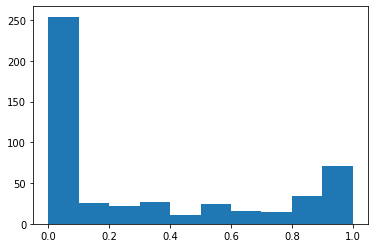

In [35]:
plt.hist(predictions)

In [36]:
predictions2 = model2.predict(val_x)
for k in range(3):
  print(predictions2[k])


[7.5523974e-05]
[0.00075879]
[2.6049656e-05]


In [37]:
preds2 = []
for k in predictions2:
  max = 0
  idx = -1
  max_idx = 0
  for i in k:
    idx += 1
    if( i > max ):
      max_idx = idx
      max = i
  preds2.append(max_idx)

In [43]:
percent = [0.1*i for i in range(1,8)]
for p in percent:
  prediction = [0 if k < p else 1 for k in predictions]

  f1 = f1_score(val_y, prediction)
  prec = precision_score(val_y, prediction)
  rec = recall_score(val_y, prediction)

  print(f'The f1 score is {f1} the \n \
        precision is {prec} and the \n \
        recall is {rec}')
  print(f' This is with threshold {p}\n------------------------------\n')


The f1 score is 0.6649616368286445 the 
         precision is 0.5284552845528455 and the 
         recall is 0.896551724137931
 This is with threshold 0.1
------------------------------

The f1 score is 0.6904109589041095 the 
         precision is 0.5727272727272728 and the 
         recall is 0.8689655172413793
 This is with threshold 0.2
------------------------------

The f1 score is 0.6822157434402332 the 
         precision is 0.5909090909090909 and the 
         recall is 0.8068965517241379
 This is with threshold 0.30000000000000004
------------------------------

The f1 score is 0.7025316455696203 the 
         precision is 0.6491228070175439 and the 
         recall is 0.7655172413793103
 This is with threshold 0.4
------------------------------

The f1 score is 0.701639344262295 the 
         precision is 0.66875 and the 
         recall is 0.7379310344827587
 This is with threshold 0.5
------------------------------

The f1 score is 0.704626334519573 the 
         precision